Calculate Average(Salary) by Company
Calculate Sum(Salary) by Dept
If the above CSV dataset is very large and updated realtime - propose alternative designs.

In [1]:
import time
import pandas as pd
import pyspark.sql.functions as func
import matplotlib.pyplot as plt
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext(('local[30]'))
spark = SparkSession(sc)
spark = SparkSession \
   .builder \
   .appName("PySpark Sample") \
   .config("spark.some.config.option", "some-value") \
   .getOrCreate()


class DataAccess:
    name = ""
    
    def __init__(self, name):
        self.name = name
        
    def get_pandas_csv(self,file_path):
        mylist = []
        for chunk in  pd.read_csv(file_path, chunksize=10000000):
            mylist.append(chunk)
        train_pandas = pd.concat(mylist, axis= 0)
        del mylist
        return train_pandas
    
    def get_spark_csv(self,file_path):
        train_spark = spark.read.csv('train.csv',header=True)
        return train_spark
    
    def get_parallel_from_spark_df(self,train_selected):
        b = sc.parallelize(train_selected.take(30000))
        train_selected_parallel = b.toDF()
        return train_selected_parallel

class DataAggregate(DataAccess):
      name = ""
      
      def __init__(self,name):
        super().__init__(name)
        self.name = name

In [2]:
data_access = DataAccess("Data_Access_1")
train_pandas = data_access.get_pandas_csv('train.csv')
train_spark = data_access.get_spark_csv('train.csv')
train_spark = train_spark.withColumn("Total_Revenue",train_spark.Total_Revenue.cast("integer"))
count = train_spark.count()
train_selected = train_spark.select("Region","Total_Revenue")
train_selected_parallel = data_access.get_parallel_from_spark_df(train_selected)

In [3]:
#Calculate time to find sum and average using pandas
start_time = time.time()
pandas_sum = train_pandas.groupby("Region")["Total_Revenue"].sum()
pandas_avg = pandas_sum/count
pandas_time = time.time() - start_time
#Calculate time to find sum and average using spark
start_time = time.time()
spark_avg = train_spark.groupBy("Region").agg(func.sum("Total_Revenue"),func.avg("Total_Revenue"))
spark_time = time.time() - start_time
#Calculate time to find sum and average using pandas with extraneous columns removed
start_time = time.time()
train_selected.groupBy("Region").agg(func.sum("Total_Revenue"),func.avg("Total_Revenue"))
spark_selected_time = time.time() - start_time
#Calculate time to find sum and average using pandas with extraneous columns removed and a parallelized dataframe
start_time = time.time()
train_selected_parallel.groupBy("Region").agg(func.sum("Total_Revenue"),func.avg("Total_Revenue"))
spark_selected_parallel_time = time.time() - start_time

pandas time to find average:  14.649901628494263
spark_time to find average:  0.29099297523498535
spark_selected_time to find average:  0.14577078819274902
spark_selected_parallel_time to find average:  0.12355995178222656


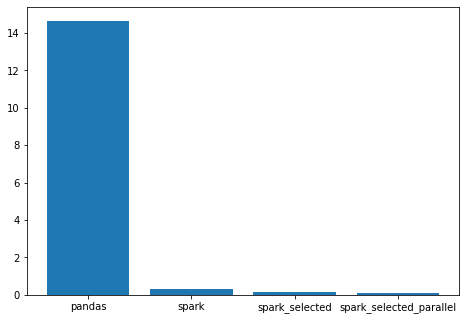

In [4]:
print("pandas time to find average: ",pandas_time)
print("spark_time to find average: ",spark_time)
print("spark_selected_time to find average: ",spark_selected_time)
print("spark_selected_parallel_time to find average: ",spark_selected_parallel_time)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
types = ['pandas', 'spark', 'spark_selected', 'spark_selected_parallel']
times = [pandas_time,spark_time,spark_selected_time,spark_selected_parallel_time]
ax.bar(types,times)
plt.show()